In [1]:
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [5]:
df = pd.read_csv('updated_merged_cic_andmal2017.csv')

# Drop duplicates and handle missing values
df = df.drop_duplicates().dropna()

# Drop non-numeric columns (like file names)
if 'filename' in df.columns:  # Adjust based on your actual column names
    df = df.drop(columns=['filename'])

# Convert categorical features to numerical if needed (use label encoding)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Print updated data types (for debugging)
print(df.dtypes)

label                 int8
app_name             int16
total_methods        int64
version_code       float64
file_size_kb       float64
num_files            int64
package_name         int16
version_name          int8
num_receivers        int64
num_intents          int64
num_services         int64
num_permissions      int64
num_activities       int64
has_native_code      int64
num_providers        int64
dtype: object


Debugging class counts:
class_name
benign        1700
adware          84
ransomware     100
scareware      108
smsmalware     109
Name: count, dtype: int64


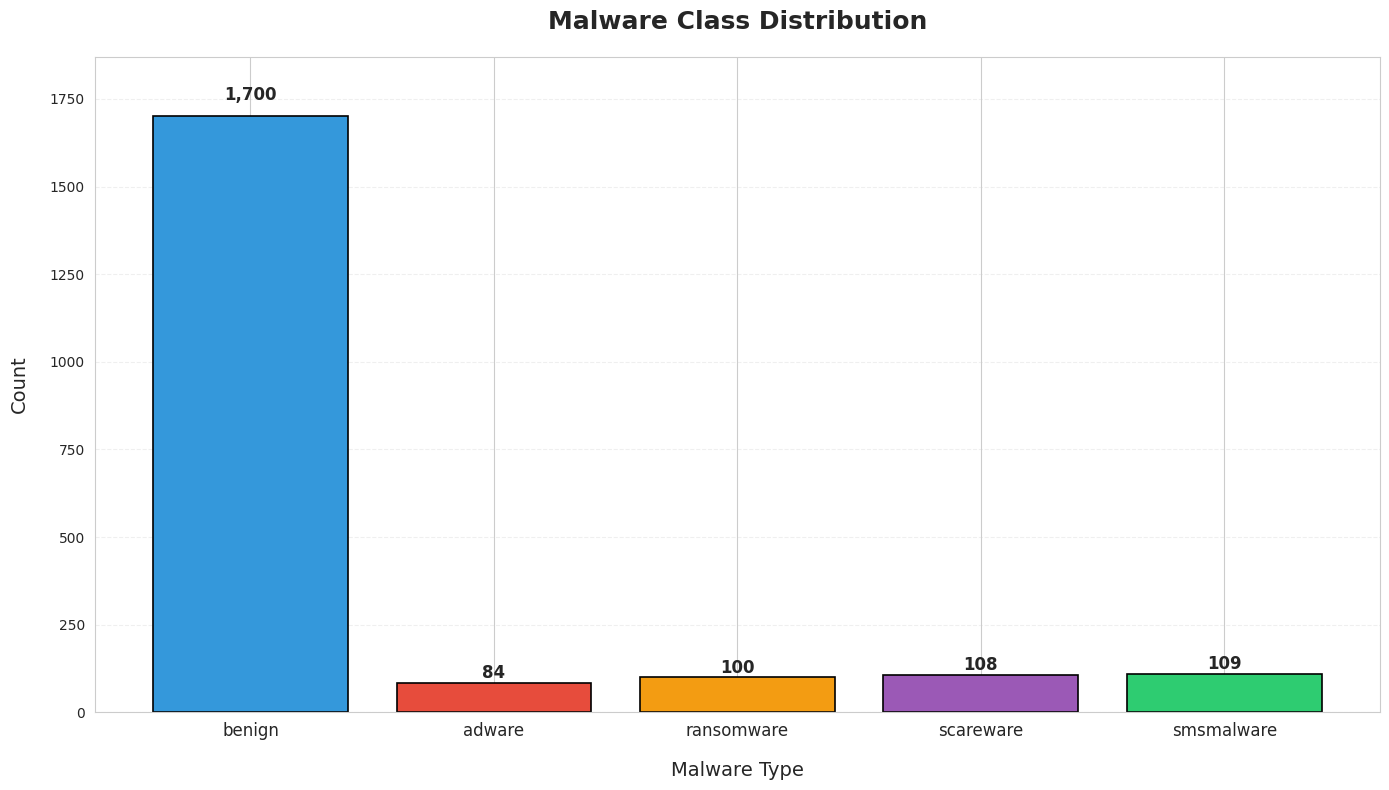

In [13]:
# Define custom mapping for labels
label_remap = {1: 'benign', 0: 'adware', 2: 'ransomware', 3: 'scareware', 4: 'smsmalware'}

# Apply mapping to the 'label' column
df['class_name'] = df['label'].map(label_remap)

# Count the occurrences of each class
class_counts = df['class_name'].value_counts()

# Ensure all classes are displayed (even if count is 0)
expected_classes = ['benign', 'adware', 'ransomware', 'scareware', 'smsmalware']
class_counts = class_counts.reindex(expected_classes, fill_value=0)

# Debugging printout
print("Debugging class counts:")
print(class_counts)

# Plot the data
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
bars = plt.bar(class_counts.index, class_counts.values,
               color=['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'],
               edgecolor='black', linewidth=1.2)

plt.title('Malware Class Distribution', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Malware Type', fontsize=14, labelpad=15)
plt.ylabel('Count', fontsize=14, labelpad=15)
plt.xticks(rotation=0, fontsize=12)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height*0.02),
             f'{int(height):,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Set y-axis to start at 0
plt.ylim(0, max(class_counts.values) * 1.1)  # Add 10% padding at the top
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('malware_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Class counts after undersampling:
class_name
benign        900
adware         84
ransomware     84
scareware      84
smsmalware     84
Name: count, dtype: int64


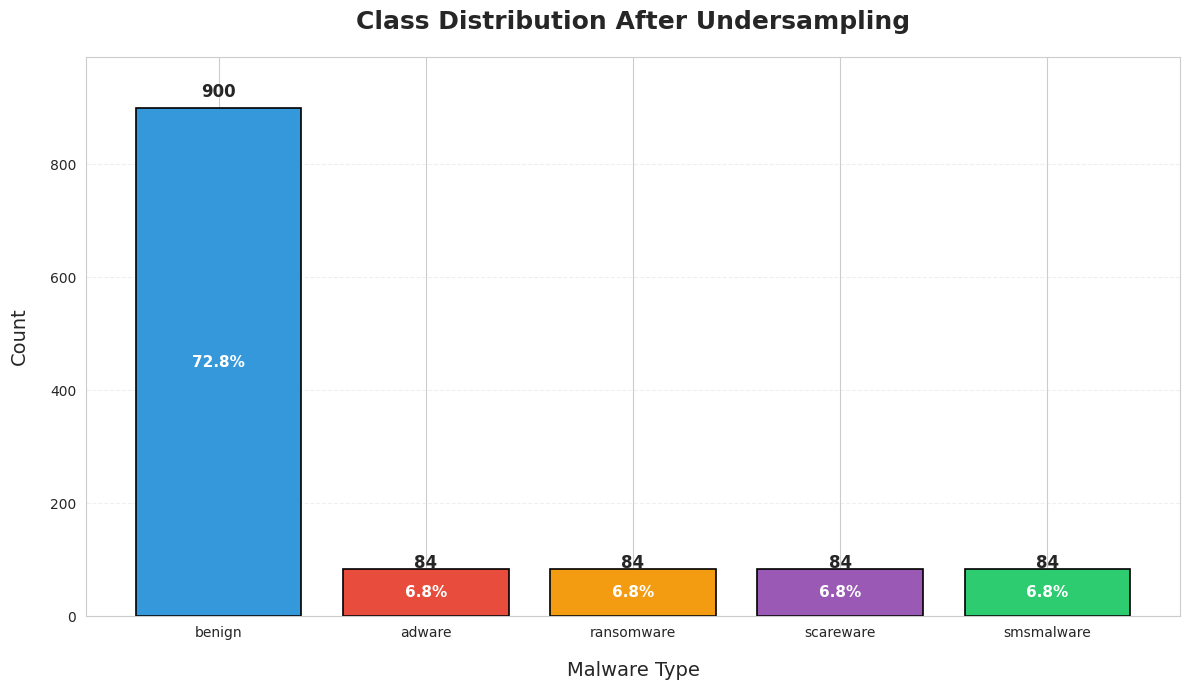


Undersampled Dataset Summary:
--------------------------------------------------
benign: 900 samples (72.8%)
adware: 84 samples (6.8%)
ransomware: 84 samples (6.8%)
scareware: 84 samples (6.8%)
smsmalware: 84 samples (6.8%)
--------------------------------------------------
Total samples: 1,236


In [16]:
# Apply Random Undersampling with specific target counts
target_count = {
    1: 900,  # benign
    4: 84,   # smsmalware
    3: 84,   # scareware
    2: 84,   # ransomware
    0: 84    # adware
}

# Apply Random Undersampling
rus = RandomUnderSampler(sampling_strategy=target_count, random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['label']), df['label'])

# Create a new DataFrame with undersampled data
df_undersampled = pd.DataFrame(X_resampled, columns=X.columns)
df_undersampled['label'] = y_resampled
df_undersampled['class_name'] = df_undersampled['label'].map(label_remap)

# Count the occurrences of each class in the undersampled data
undersampled_class_counts = df_undersampled['class_name'].value_counts()

# Ensure all classes are displayed in the expected order
undersampled_class_counts = undersampled_class_counts.reindex(expected_classes, fill_value=0)

print("Class counts after undersampling:")
print(undersampled_class_counts)

# Create a single plot for the undersampled data
plt.figure(figsize=(12, 7))

# Plot undersampled distribution
bars = plt.bar(undersampled_class_counts.index, undersampled_class_counts.values,
       color=['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'],
       edgecolor='black', linewidth=1.2)

plt.title('Class Distribution After Undersampling', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Malware Type', fontsize=14, labelpad=15)
plt.ylabel('Count', fontsize=14, labelpad=15)
plt.tick_params(axis='x', rotation=0)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{int(height):,}', ha='center', fontsize=12, fontweight='bold')

# Add percentage labels inside bars
total = undersampled_class_counts.sum()
for i, bar in enumerate(bars):
    if bar.get_height() > 0:
        percentage = (undersampled_class_counts.values[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
                f'{percentage:.1f}%', 
                ha='center', va='center', fontsize=11, 
                color='white', fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, max(undersampled_class_counts.values) * 1.1)  # Add 10% padding at the top

plt.tight_layout()
plt.savefig('undersampled_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics of the undersampled dataset
print("\nUndersampled Dataset Summary:")
print("-" * 50)
for name, count in zip(undersampled_class_counts.index, undersampled_class_counts.values):
    print(f"{name}: {int(count):,} samples ({count/total*100:.1f}%)")
print("-" * 50)
print(f"Total samples: {int(total):,}")

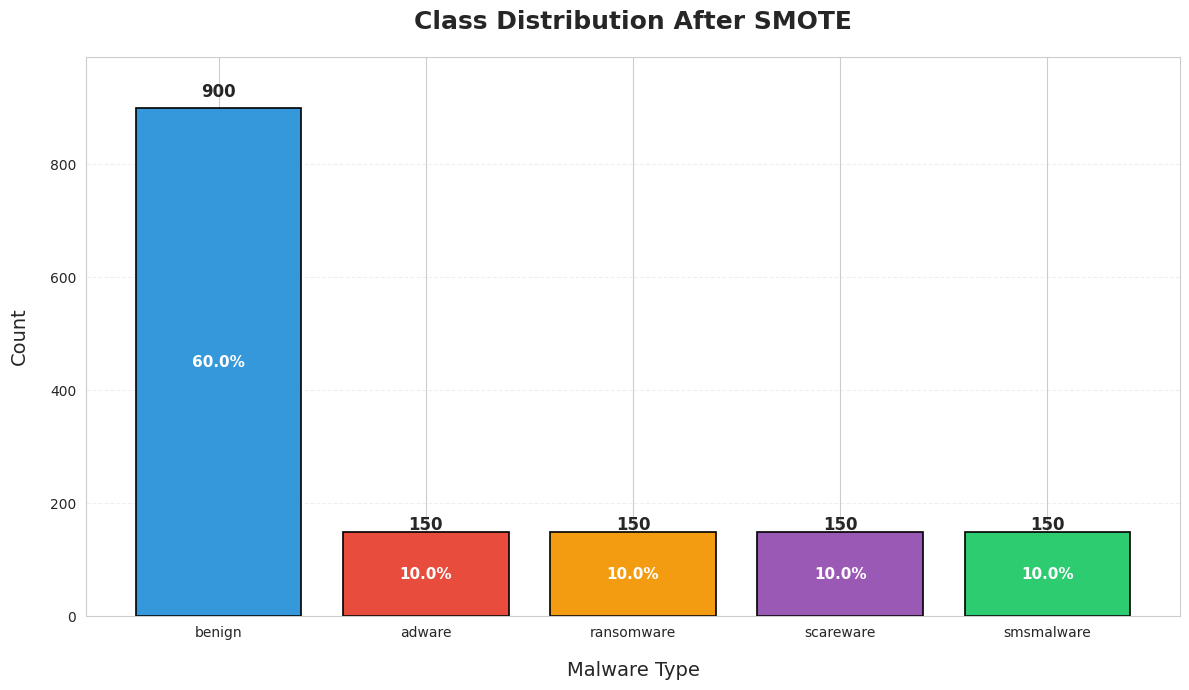


Distribution After SMOTE:
--------------------------------------------------
benign: 900 samples (60.0%)
adware: 150 samples (10.0%)
ransomware: 150 samples (10.0%)
scareware: 150 samples (10.0%)
smsmalware: 150 samples (10.0%)
--------------------------------------------------
Total samples: 1,500


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Define the label mapping
label_remap = {1: 'benign', 0: 'adware', 2: 'ransomware', 3: 'scareware', 4: 'smsmalware'}
expected_classes = ['benign', 'adware', 'ransomware', 'scareware', 'smsmalware']

# Load original dataset
df = pd.read_csv('updated_merged_cic_andmal2017.csv')

# Data preprocessing (same as in balance_code.py)
df = df.drop_duplicates().dropna()
if 'filename' in df.columns:
    df = df.drop(columns=['filename'])
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Step 1: Undersampling
target_count = {
    1: 900,  # benign
    4: 84,   # smsmalware
    3: 84,   # scareware
    2: 84,   # ransomware
    0: 84    # adware
}
rus = RandomUnderSampler(sampling_strategy=target_count, random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['label']), df['label'])

# Step 2: Apply SMOTE
smote = BorderlineSMOTE(sampling_strategy={
    3: 150,  # scareware
    4: 150,  # smsmalware
    2: 150,  # ransomware
    0: 150   # adware
}, random_state=42)
X_smote, y_smote = smote.fit_resample(X_resampled, y_resampled)

# Create DataFrames for each step
df_resampled = pd.DataFrame(X_resampled, columns=df.drop(columns=['label']).columns)
df_resampled['label'] = y_resampled
df_resampled['class_name'] = df_resampled['label'].map(label_remap)

df_smote = pd.DataFrame(X_smote, columns=df.drop(columns=['label']).columns)
df_smote['label'] = y_smote
df_smote['class_name'] = df_smote['label'].map(label_remap)

# Get class counts
smote_class_counts = df_smote['class_name'].value_counts().reindex(expected_classes, fill_value=0)

# Create the visualization
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Plot SMOTE distribution
bars = plt.bar(smote_class_counts.index, smote_class_counts.values,
       color=['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'],
       edgecolor='black', linewidth=1.2)

plt.title('Class Distribution After SMOTE', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Malware Type', fontsize=14, labelpad=15)
plt.ylabel('Count', fontsize=14, labelpad=15)
plt.tick_params(axis='x', rotation=0)

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{int(height):,}', ha='center', fontsize=12, fontweight='bold')

# Add percentage labels
total = smote_class_counts.sum()
for i, bar in enumerate(bars):
    if bar.get_height() > 0:
        percentage = (smote_class_counts.values[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
                f'{percentage:.1f}%', 
                ha='center', va='center', fontsize=11, 
                color='white', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, max(smote_class_counts.values) * 1.1)

plt.tight_layout()
plt.savefig('smote_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nDistribution After SMOTE:")
print("-" * 50)
for name, count in zip(smote_class_counts.index, smote_class_counts.values):
    print(f"{name}: {int(count):,} samples ({count/total*100:.1f}%)")
print("-" * 50)
print(f"Total samples: {int(total):,}")

Precision Score of SMOTE Data: 0.9074


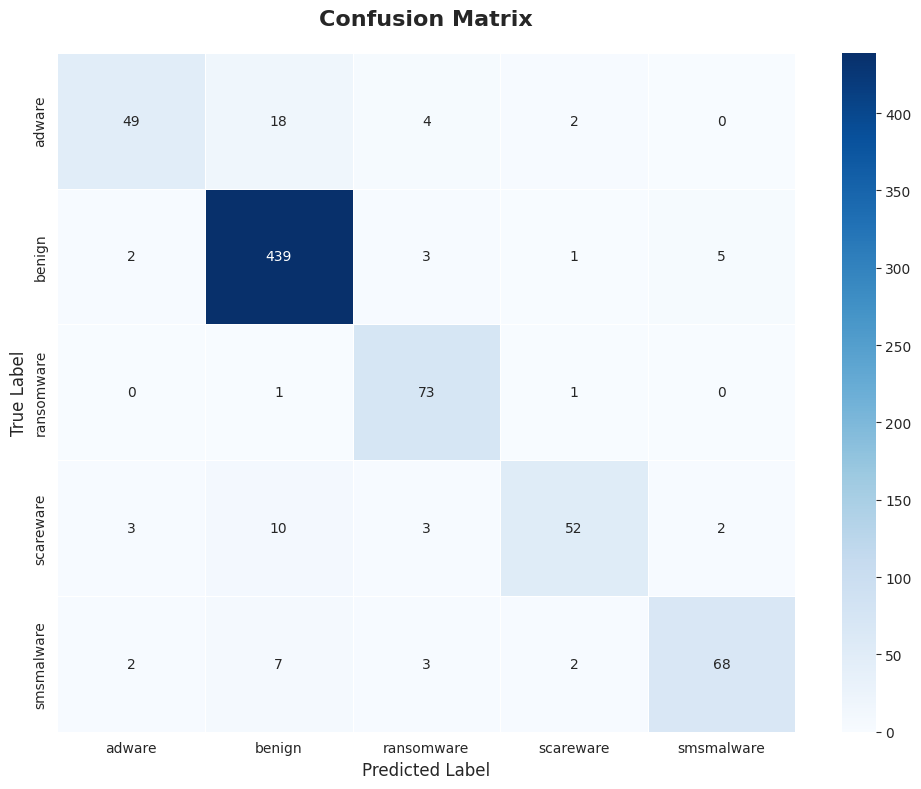


Classification Report:
              precision    recall  f1-score   support

      adware       0.88      0.67      0.76        73
      benign       0.92      0.98      0.95       450
  ransomware       0.85      0.97      0.91        75
   scareware       0.90      0.74      0.81        70
  smsmalware       0.91      0.83      0.87        82

    accuracy                           0.91       750
   macro avg       0.89      0.84      0.86       750
weighted avg       0.91      0.91      0.90       750


Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision  Recall     F1-Score   Support   
----------------------------------------------------------------------
adware          0.8750      0.6712      0.7597      73
benign          0.9242      0.9756      0.9492      450
ransomware      0.8488      0.9733      0.9068      75
scareware       0.8966      0.7429      0.8125      70
smsmalware      0.9067      0.8293      0.86

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split the SMOTE data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.5, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score of SMOTE Data: {precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class label mapping for display
label_remap = {1: 'benign', 0: 'adware', 2: 'ransomware', 3: 'scareware', 4: 'smsmalware'}
classes = [label_remap[i] for i in sorted(np.unique(y_test))]

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)

# Add labels and title
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)

# Improve visibility
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

# Calculate and print per-class precision, recall, and F1-score
print("\nPer-Class Metrics:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 70)

# Get metrics for each class
from sklearn.metrics import precision_recall_fscore_support
prfs = precision_recall_fscore_support(y_test, y_pred)

for i, cls in enumerate(classes):
    print(f"{cls:<15} {prfs[0][i]:.4f}      {prfs[1][i]:.4f}      {prfs[2][i]:.4f}      {prfs[3][i]}")

print("-" * 70)

/tmp/ipykernel_5069/605858842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=colors)


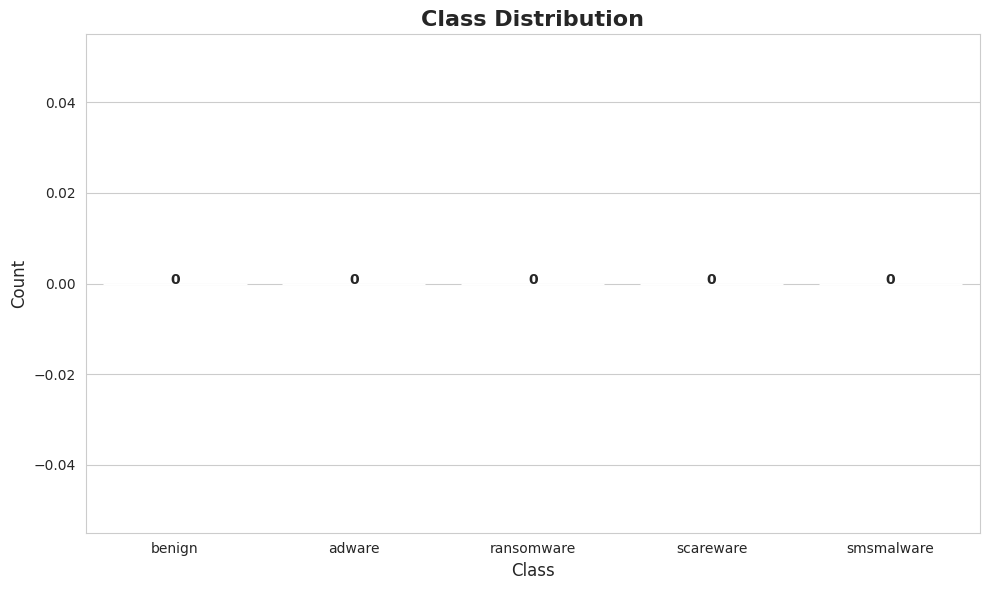

In [23]:
# Count the occurrences of each class in the dataset
class_distribution = y.value_counts().reindex(expected_classes, fill_value=0)

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=colors)

# Add labels and title
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of each bar
for i, count in enumerate(class_distribution.values):
    plt.text(i, count + (count * 0.01), f'{count:,}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()